# Problemstellung

Im Folgenden wird ein neurnales Netz mithlfe eines Voting-Classifiers, der auf verschiedenen Decision-Tree-Algorithmen basiert, aufgebaut, trainiert und getestet. Zum Abschluss wird die KO-Phase der Fußball-Weltmeisterschaft 2018 ausgewertet.

Der Datensatz wird dabei so aufgebaut, dass zwei Listen an Spielern gegenüber gestellt werden. Getestet wurden dabei verschiedene Varianten

# Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import scipy as sp
import itertools
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomTreesEmbedding, VotingClassifier, RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score

# Helper

In [2]:
# from scikit-learn
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Datensätze

## Line-Up mit Spielernamen

In [3]:
fifa_names = pd.read_csv("data/data_names.csv", encoding='utf8', index_col=None, header=None)
fifa_names.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1.465510e+09,Hugo Lloris,Patrice Evra,Adil Rami,Bacary Sagna,Laurent Koscielny,NGolo Kanté,Dimitri Payet,Blaise Matuidi,Paul Pogba,...,Vlad Chiricheş,Dragoş Grigore,Cristian Săpunaru,Ovidiu Hoban,Mihai Pintilii,Nicolae Stanciu,Adrian Popa,Florin Andone,Bogdan Stancu,1
1,1.465596e+09,Etrit Berisha,Ermir Lenjani,Elseid Hysaj,Lorik Cana,Ansi Agolli,Mergim Mavraj,Burim Kukeli,Taulant Xhaka,Odise Roshi,...,Ricardo Rodríguez,Johan Djourou,Fabian Schär,Granit Xhaka,Valon Behrami,Blerim Džemaili,Xherdan Shaqiri,Haris Seferović,Admir Mehmedi,2
2,1.465942e+09,Hugo Lloris,Patrice Evra,Adil Rami,Bacary Sagna,Laurent Koscielny,NGolo Kanté,Dimitri Payet,Blaise Matuidi,Olivier Giroud,...,Ermir Lenjani,Elseid Hysaj,Ansi Agolli,Mergim Mavraj,Arlind Ajeti,Ledian Memushaj,Burim Kukeli,Amir Abrashi,Armando Sadiku,1
3,1.465942e+09,Ciprian Tătăruşanu,Răzvan Raţ,Vlad Chiricheş,Dragoş Grigore,Cristian Săpunaru,Alexandru Chipciu,Mihai Pintilii,Gabriel Torje,Andrei Prepelită,...,Ricardo Rodríguez,Johan Djourou,Fabian Schär,Granit Xhaka,Valon Behrami,Blerim Džemaili,Xherdan Shaqiri,Haris Seferović,Admir Mehmedi,0
4,1.466287e+09,Yann Sommer,Stephan Lichtsteiner,Ricardo Rodríguez,Johan Djourou,Fabian Schär,Granit Xhaka,Valon Behrami,Blerim Džemaili,Xherdan Shaqiri,...,Adil Rami,Bacary Sagna,Laurent Koscielny,Yohan Cabaye,Paul Pogba,Moussa Sissoko,Antoine Griezmann,André-Pierre Gignac,Kingsley Coman,0


### timestamp verwerfen

In [4]:
fifa_names.drop([0], axis=1).head()

,1,2,3,4,5,6,7,8,9,10,...,14,15,16,17,18,19,20,21,22,23
0,Hugo Lloris,Patrice Evra,Adil Rami,Bacary Sagna,Laurent Koscielny,NGolo Kanté,Dimitri Payet,Blaise Matuidi,Paul Pogba,Antoine Griezmann,...,Vlad Chiricheş,Dragoş Grigore,Cristian Săpunaru,Ovidiu Hoban,Mihai Pintilii,Nicolae Stanciu,Adrian Popa,Florin Andone,Bogdan Stancu,1
1,Etrit Berisha,Ermir Lenjani,Elseid Hysaj,Lorik Cana,Ansi Agolli,Mergim Mavraj,Burim Kukeli,Taulant Xhaka,Odise Roshi,Amir Abrashi,...,Ricardo Rodríguez,Johan Djourou,Fabian Schär,Granit Xhaka,Valon Behrami,Blerim Džemaili,Xherdan Shaqiri,Haris Seferović,Admir Mehmedi,2
2,Hugo Lloris,Patrice Evra,Adil Rami,Bacary Sagna,Laurent Koscielny,NGolo Kanté,Dimitri Payet,Blaise Matuidi,Olivier Giroud,Anthony Martial,...,Ermir Lenjani,Elseid Hysaj,Ansi Agolli,Mergim Mavraj,Arlind Ajeti,Ledian Memushaj,Burim Kukeli,Amir Abrashi,Armando Sadiku,1
3,Ciprian Tătăruşanu,Răzvan Raţ,Vlad Chiricheş,Dragoş Grigore,Cristian Săpunaru,Alexandru Chipciu,Mihai Pintilii,Gabriel Torje,Andrei Prepelită,Claudiu Keșerü,...,Ricardo Rodríguez,Johan Djourou,Fabian Schär,Granit Xhaka,Valon Behrami,Blerim Džemaili,Xherdan Shaqiri,Haris Seferović,Admir Mehmedi,0
4,Yann Sommer,Stephan Lichtsteiner,Ricardo Rodríguez,Johan Djourou,Fabian Schär,Granit Xhaka,Valon Behrami,Blerim Džemaili,Xherdan Shaqiri,Breel Embolo,...,Adil Rami,Bacary Sagna,Laurent Koscielny,Yohan Cabaye,Paul Pogba,Moussa Sissoko,Antoine Griezmann,André-Pierre Gignac,Kingsley Coman,0


### Team 1

In [5]:
fifa_names.loc[:,1:11].head()

,1,2,3,4,5,6,7,8,9,10,11
0,Hugo Lloris,Patrice Evra,Adil Rami,Bacary Sagna,Laurent Koscielny,NGolo Kanté,Dimitri Payet,Blaise Matuidi,Paul Pogba,Antoine Griezmann,Olivier Giroud
1,Etrit Berisha,Ermir Lenjani,Elseid Hysaj,Lorik Cana,Ansi Agolli,Mergim Mavraj,Burim Kukeli,Taulant Xhaka,Odise Roshi,Amir Abrashi,Armando Sadiku
2,Hugo Lloris,Patrice Evra,Adil Rami,Bacary Sagna,Laurent Koscielny,NGolo Kanté,Dimitri Payet,Blaise Matuidi,Olivier Giroud,Anthony Martial,Kingsley Coman
3,Ciprian Tătăruşanu,Răzvan Raţ,Vlad Chiricheş,Dragoş Grigore,Cristian Săpunaru,Alexandru Chipciu,Mihai Pintilii,Gabriel Torje,Andrei Prepelită,Claudiu Keșerü,Bogdan Stancu
4,Yann Sommer,Stephan Lichtsteiner,Ricardo Rodríguez,Johan Djourou,Fabian Schär,Granit Xhaka,Valon Behrami,Blerim Džemaili,Xherdan Shaqiri,Breel Embolo,Admir Mehmedi


### Team 2

In [6]:
fifa_names.loc[:,12:22].head()

,12,13,14,15,16,17,18,19,20,21,22
0,Ciprian Tătăruşanu,Răzvan Raţ,Vlad Chiricheş,Dragoş Grigore,Cristian Săpunaru,Ovidiu Hoban,Mihai Pintilii,Nicolae Stanciu,Adrian Popa,Florin Andone,Bogdan Stancu
1,Yann Sommer,Stephan Lichtsteiner,Ricardo Rodríguez,Johan Djourou,Fabian Schär,Granit Xhaka,Valon Behrami,Blerim Džemaili,Xherdan Shaqiri,Haris Seferović,Admir Mehmedi
2,Etrit Berisha,Andi Lila,Ermir Lenjani,Elseid Hysaj,Ansi Agolli,Mergim Mavraj,Arlind Ajeti,Ledian Memushaj,Burim Kukeli,Amir Abrashi,Armando Sadiku
3,Yann Sommer,Stephan Lichtsteiner,Ricardo Rodríguez,Johan Djourou,Fabian Schär,Granit Xhaka,Valon Behrami,Blerim Džemaili,Xherdan Shaqiri,Haris Seferović,Admir Mehmedi
4,Hugo Lloris,Patrice Evra,Adil Rami,Bacary Sagna,Laurent Koscielny,Yohan Cabaye,Paul Pogba,Moussa Sissoko,Antoine Griezmann,André-Pierre Gignac,Kingsley Coman


### Ergebnis

In [7]:
fifa_names.loc[:,23].head()

0    1
1    2
2    1
3    0
4    0
Name: 23, dtype: int64

## LineUp mit Spieler IDs

In [12]:
types = {k: np.string_ for k in range(25)}
fifa_simple = pd.read_csv("data/data_simple_train.csv", encoding='utf8', dtype=types, index_col=None, header=None)
fifa_simple.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,8275449,SueperLig,2016-2017,1487890800.0,Ramazan Köse,Titi,Loret Sadiku,Olivier Veigneau,Abdullah Durak,Castro,...,Ertuğrul Ersoy,Boban Jovič,Onur Atasayar,Tomáš Sivok,Cristóbal Jorquera,Pablo Batalla,Ricardo Faty,Kubilay Kanatsızkuş,Bogdan Stancu,1
1,8275447,SueperLig,2016-2017,1487977200.0,Haydar Yilmaz,Fabrice NSakala,Giorgos Tzavellas,Kenneth Omeruo,Lamine Gassama,Efecan Karaca,...,Maurício Ramos,Emre Uruç,Renan Diniz,Tevfik Altındağ,Renan Foguinho,Vladimir Koman,Roni,Reynaldo,Vinícius,1
2,8275446,SueperLig,2016-2017,1487977200.0,Bora Körk,Miguel Lopes,Ömer Bayram,Mustafa Yumlu,Caner Osmanpaşa,Özer Hurmacı,...,Sakıb Aytaç,Ondřej Čelůstka,Diego Ângelo,Zeki Yildirim,Charles,Danilo,Mbilla Etame,Samuel Etoo,Deniz Kadah,1
3,8275450,SueperLig,2016-2017,1488063600.0,Žydrūnas Karčemarskas,Tiago Pinto,Václav Procházka,Numan Çürüksu,Avdija Vršajević,Mehmet Güven,...,Alexandru Epureanu,Alparslan Erdem,Junior Caiçara,Emre Belözoğlu,Edin Višća,Márcio Mossoró,Cengiz Ünder,Mahmut Tekdemir,Mustafa Pektemek,2
4,8275443,SueperLig,2016-2017,1488150000.0,Fernando Muslera,Aurélien Chedjou,Hakan Balta,Lionel Carole,Semih Kaya,Yasin Öztekin,...,Marcelo,Atınç Nukan,Gökhan Gönül,Atiba Hutchinson,Oğuzhan Özyakup,Anderson Talisca,Ricardo Quaresma,Cenk Tosun,Ryan Babel,2


## LineUp mit Spieler IDs als Index

#### LineUp alle Spieler gegen alle Spieler (1: nimmt teil, 0: nimmt nicht teil)

In [13]:
types = {k: np.int32 for k in range(21546)}
fifa_complex = pd.read_csv("data/data_complex_train.csv", encoding='utf8', dtype=types, index_col=None, header=None)
fifa_complex.head()

,0,1,2,3,4,5,6,7,8,9,...,21532,21533,21534,21535,21536,21537,21538,21539,21540,21541
0,1465509600,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1465596000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,1465941600,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1465941600,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1466287200,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Jeder Spieler existiert zweimal

In [14]:
half = int(fifa_complex.shape[1] / 2)
fifa_complex.loc[:,half-8:half+8].head()

,10763,10764,10765,10766,10767,10768,10769,10770,10771,10772,10773,10774,10775,10776,10777,10778,10779
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Datensatz testen

In [15]:
# teams should have 11 players each
N = 1000
home = 0
away = 0

rows = fifa_complex.shape[0]
cols = fifa_complex.shape[1]
valid = True
for row in np.random.randint(rows, size=N):
    players = fifa_complex.loc[row].values
    players_team_home = sum(players[1:int(cols / 2)])
    players_team_away = sum(players[int(cols / 2):-1])
    
    valid = valid and (players_team_home == players_team_away == 11)
    if not (players_team_home == players_team_away == 11):
        print(row)
        print(players_team_home)
        print(players_team_away)
        
print("Getestete Datensätze: %d, Valide: %r" % (N, valid))

Getestete Datensätze: 1000, Valide: True


# Feature Set, Sparse Matrix und Train/Test Split

In [16]:
feature = fifa_complex.drop([0,fifa_complex.shape[1]-1], axis=1).values
target = fifa_complex[fifa_complex.shape[1]-1].values

feature_csc = sp.sparse.csc_matrix(feature)
feature_csr = sp.sparse.csr_matrix(feature)

In [17]:
print(feature_csc)

  (2882, 0)	1
  (3882, 0)	1
  (3903, 0)	1
  (3933, 0)	1
  (3947, 0)	1
  (3953, 0)	1
  (3980, 0)	1
  (3987, 0)	1
  (4012, 0)	1
  (4042, 0)	1
  (4054, 0)	1
  (4060, 0)	1
  (4072, 0)	1
  (4097, 0)	1
  (4114, 0)	1
  (4135, 0)	1
  (4156, 0)	1
  (4173, 0)	1
  (5519, 0)	1
  (5532, 0)	1
  (5551, 0)	1
  (5567, 0)	1
  (5579, 0)	1
  (5585, 0)	1
  (5617, 0)	1
  :	:
  (4902, 21537)	1
  (4916, 21537)	1
  (4919, 21537)	1
  (4946, 21537)	1
  (4990, 21537)	1
  (5063, 21537)	1
  (5064, 21537)	1
  (5077, 21537)	1
  (5105, 21537)	1
  (5118, 21537)	1
  (5159, 21537)	1
  (5197, 21537)	1
  (5237, 21537)	1
  (674, 21538)	1
  (704, 21538)	1
  (709, 21538)	1
  (721, 21538)	1
  (4454, 21538)	1
  (4472, 21538)	1
  (4483, 21538)	1
  (4495, 21538)	1
  (4504, 21538)	1
  (4526, 21538)	1
  (4545, 21538)	1
  (171, 21539)	1


In [18]:
print(feature_csr)

  (0, 1628)	1
  (0, 1973)	1
  (0, 2516)	1
  (0, 3225)	1
  (0, 4448)	1
  (0, 5099)	1
  (0, 5382)	1
  (0, 6600)	1
  (0, 7385)	1
  (0, 9186)	1
  (0, 9963)	1
  (0, 11676)	1
  (0, 12158)	1
  (0, 12642)	1
  (0, 12717)	1
  (0, 15912)	1
  (0, 16195)	1
  (0, 16440)	1
  (0, 16735)	1
  (0, 17681)	1
  (0, 18177)	1
  (0, 19760)	1
  (1, 752)	1
  (1, 1946)	1
  (1, 3089)	1
  :	:
  (6467, 18560)	1
  (6467, 18796)	1
  (6467, 21157)	1
  (6468, 238)	1
  (6468, 311)	1
  (6468, 1341)	1
  (6468, 2513)	1
  (6468, 2687)	1
  (6468, 4855)	1
  (6468, 4924)	1
  (6468, 5126)	1
  (6468, 7309)	1
  (6468, 9350)	1
  (6468, 9519)	1
  (6468, 11007)	1
  (6468, 11637)	1
  (6468, 12857)	1
  (6468, 13011)	1
  (6468, 16135)	1
  (6468, 16223)	1
  (6468, 16983)	1
  (6468, 17742)	1
  (6468, 17787)	1
  (6468, 18855)	1
  (6468, 20812)	1


In [19]:
X_train, X_test, y_train, y_test = train_test_split(feature_csr, target, test_size=0.2)

print('Trainingsdaten: %d' % X_train.shape[0])
print('Testdaten: %d' % X_test.shape[0])

Trainingsdaten: 5175
Testdaten: 1294


# Erwartungswerte

## Primitives Raten

In [20]:
guesses = np.random.randint(3, size=len(target))
matches = sum([int(r == g) for r, g in zip(target, guesses)])

print("Richtigkeit: %0.3f [%s]" % (matches / len(target), 'primitive guessing'))

Richtigkeit: 0.335 [primitive guessing]


## Relatives Raten

In [21]:
distribution={
    0: sum([int(r == 0) for r in target]) / len(target),
    1: sum([int(r == 1) for r in target]) / len(target),
    2: sum([int(r == 2) for r in target]) / len(target)
}

guesses = []
for i in range(len(target)):
    rnd = random.random()
    
    guesses.append(
        0 if rnd <= distribution[0] else 1 if rnd <= distribution[0] + distribution[1] else 2
    )
    
matches = sum([int(r == g) for r, g in zip(target, guesses)])

print("Richtigkeit: %0.3f [%s]" % (matches / len(target), 'relative guessing'))

Richtigkeit: 0.358 [relative guessing]


# Classifier Vergleich

In [22]:
classifiers = [
    LinearSVC(),
    SVC(),
    #NuSVC(),
    DecisionTreeClassifier(),
    KNeighborsClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    ExtraTreesClassifier(),
    BaggingClassifier(),
    GradientBoostingClassifier()
]

In [23]:
for i, clf in enumerate(classifiers):
    c = clf.fit(X_train, y_train)
    scores = clf.score(X_test, y_test)
    print("Richtigkeit: %0.3f [%s]" % (scores.mean(), type(c).__name__))

Richtigkeit: 0.471 [LinearSVC]
Richtigkeit: 0.453 [SVC]
Richtigkeit: 0.468 [DecisionTreeClassifier]
Richtigkeit: 0.455 [KNeighborsClassifier]
Richtigkeit: 0.504 [RandomForestClassifier]
Richtigkeit: 0.506 [AdaBoostClassifier]
Richtigkeit: 0.509 [ExtraTreesClassifier]
Richtigkeit: 0.490 [BaggingClassifier]
Richtigkeit: 0.506 [GradientBoostingClassifier]


# Bewertung und Darstellung der Ergebnisse

## Decision Trees

In [24]:
classifierDecisionTree = [
    DecisionTreeClassifier(criterion='gini'), #default
    DecisionTreeClassifier(criterion='entropy'),
    DecisionTreeClassifier(splitter='best'), #default
    DecisionTreeClassifier(splitter='random'),
    DecisionTreeClassifier(class_weight='balanced'),
    DecisionTreeClassifier(max_depth=2),
    DecisionTreeClassifier(max_depth=4),
    DecisionTreeClassifier(max_depth=6),
    DecisionTreeClassifier(max_depth=8)
]

In [25]:
for i, clf in enumerate(classifierDecisionTree):
    c = clf.fit(X_train, y_train)
    scores = clf.score(X_test, y_test)
    print("Richtigkeit: %0.3f [%s]" % (scores.mean(), type(c).__name__))

Richtigkeit: 0.470 [DecisionTreeClassifier]
Richtigkeit: 0.472 [DecisionTreeClassifier]
Richtigkeit: 0.462 [DecisionTreeClassifier]
Richtigkeit: 0.455 [DecisionTreeClassifier]
Richtigkeit: 0.440 [DecisionTreeClassifier]
Richtigkeit: 0.457 [DecisionTreeClassifier]
Richtigkeit: 0.461 [DecisionTreeClassifier]
Richtigkeit: 0.462 [DecisionTreeClassifier]
Richtigkeit: 0.467 [DecisionTreeClassifier]


## Support Vector Machines

In [26]:
classifierSVMs = [
    LinearSVC(),
    SVC(kernel='linear'),
    SVC(kernel='poly'),
    SVC(kernel='rbf'), #default
    SVC(kernel='sigmoid'),
    # SVC(kernel='precomputed'),  #no suppport for sparse
    NuSVC(kernel='linear'),
    NuSVC(kernel='poly'),
    NuSVC(kernel='rbf'), #default
    NuSVC(kernel='sigmoid'),
    # NuSVC(kernel='precomputed'),  #no suppport for sparse
]

In [27]:
for i, clf in enumerate(classifierSVMs):
    c = clf.fit(X_train, y_train)
    scores = clf.score(X_test, y_test)
    print("Richtigkeit: %0.3f [%s]" % (scores.mean(), type(c).__name__))

Richtigkeit: 0.471 [LinearSVC]
Richtigkeit: 0.475 [SVC]
Richtigkeit: 0.453 [SVC]
Richtigkeit: 0.453 [SVC]
Richtigkeit: 0.453 [SVC]
Richtigkeit: 0.513 [NuSVC]
Richtigkeit: 0.420 [NuSVC]
Richtigkeit: 0.512 [NuSVC]
Richtigkeit: 0.470 [NuSVC]


## Ensemble Methods (Random Forest Classifier / Voting Classifier)

In [28]:
classifierRandomForest = [
    RandomForestClassifier(n_estimators=10,max_depth=None), #default
    RandomForestClassifier(n_estimators=100,max_depth=None),
    RandomForestClassifier(n_estimators=100,max_depth=6),
    RandomForestClassifier(n_estimators=1000,max_depth=None),
    RandomForestClassifier(n_estimators=1000,max_depth=6)
]

In [29]:
for i, clf in enumerate(classifierRandomForest):
    c = clf.fit(X_train, y_train)
    scores = clf.score(X_test, y_test)
    print("Richtigkeit: %0.3f [%s]" % (scores.mean(), type(c).__name__))

Richtigkeit: 0.506 [RandomForestClassifier]
Richtigkeit: 0.546 [RandomForestClassifier]
Richtigkeit: 0.455 [RandomForestClassifier]
Richtigkeit: 0.548 [RandomForestClassifier]
Richtigkeit: 0.453 [RandomForestClassifier]


In [30]:
clf1 = AdaBoostClassifier(algorithm='SAMME',base_estimator=NuSVC(kernel='linear', probability=True))
clf2 = RandomForestClassifier(n_estimators=10)  # (n_estimators=10750)
clf21 = RandomForestClassifier(n_estimators=100)  # (n_estimators=1000)
clf3 = BaggingClassifier(base_estimator=NuSVC(kernel='linear', probability=True))
clf4 = GradientBoostingClassifier()

classifierVoting = [
    VotingClassifier(estimators=[('ab', clf1), ('bc', clf3)], voting='soft'),
    VotingClassifier(estimators=[('ab', clf1), ('rf', clf21), ('bc', clf3), ('gb', clf4)], voting='hard'),
    VotingClassifier(estimators=[('ab', clf1), ('rf', clf21), ('bc', clf3), ('gb', clf4)], voting='soft'),
    VotingClassifier(estimators=[('ab', clf1), ('rf', clf21), ('bc', clf3)], voting='soft'),
    VotingClassifier(estimators=[('ab', clf1), ('rf', clf2), ('bc', clf3), ('gb', clf4)], voting='soft')
]

In [31]:
for i, clf in enumerate(classifierVoting):
    c = clf.fit(X_train, y_train)
    scores = clf.score(X_test, y_test)
    print("Richtigkeit: %0.3f [%s]" % (scores.mean(), type(c).__name__))

# Ergebnisse

In [32]:
clf_predict = VotingClassifier(estimators=[('ab', clf1), ('rf', clf21), ('bc', clf3)], voting='soft')

classifierResult = [
    #NuSVC(kernel='linear'),
    #RandomForestClassifier(n_estimators=100), #(n_estimators=10750),
    clf_predict
]

Richtigkeit: 0.556 (719) [VotingClassifier]


C:\Users\nons3ns\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


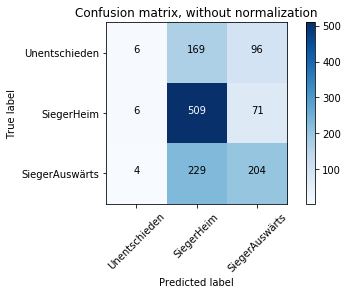

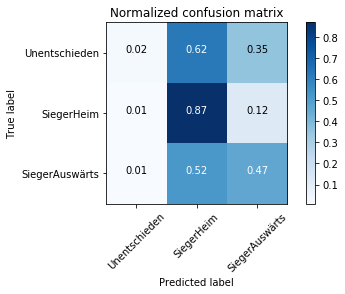

In [33]:
for i, clf in enumerate(classifierResult):
    c = clf.fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    accuracy_number = accuracy_score(y_test, y_predict, normalize=False)
    accuracy_percent = accuracy_score(y_test, y_predict)
    
    class_names = ('Unentschieden', 'SiegerHeim', 'SiegerAuswärts')
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_predict)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')
    
    print("Richtigkeit: %0.3f (%d) [%s]" % (accuracy_percent, accuracy_number, type(c).__name__))
    
    plt.show()

# WM 2018 KO-Runde

In [34]:
fifa_wm_ko = pd.read_csv("data/data_complex_test.csv", encoding='utf8', dtype=types, index_col=None, header=None)

feature_wm_ko = fifa_wm_ko.drop([0,fifa_wm_ko.shape[1]-1], axis=1).values
target_wm_ko = fifa_wm_ko[fifa_wm_ko.shape[1]-1].values

feature_wm_ko = sp.sparse.csr_matrix(feature_wm_ko)

In [35]:
fifa_wm_ko.head()

,0,1,2,3,4,5,6,7,8,9,...,21532,21533,21534,21535,21536,21537,21538,21539,21540,21541
0,1530828000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1530828000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1530914400,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1530914400,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1531173600,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
wm_predict = clf_predict.predict(feature_wm_ko)
print(wm_predict)
#accuracy_number = accuracy_score(target_wm_ko, wm_predict, normalize=False)
#accuracy_percent = accuracy_score(target_wm_ko, wm_predict)
#print("Richtigkeit: %0.3f (%d) [%s]" % (accuracy_percent, accuracy_number, type(c).__name__))

[1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 2]


C:\Users\nons3ns\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# Fazit

- Ergebnisinterpretation
- Probleme des Realbezugs
    - Keine starke statistische Signifikanz
    - Relativ geringer Datensatz für die Menge an Features
- Güte der Daten
    - Test Matching Spieler
    - Gebrochene Line-Ups